In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Conv2D,Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, SeparableConv2D , DepthwiseConv2D, concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

from keras.datasets import cifar10



Using TensorFlow backend.


In [0]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
print("Number of images in the Train dataset : {}".format(num_train))
print("Number of classes : {}".format(num_classes))
print("Shape of the train dataset : {}".format(train_features.shape))
print("Shape of the test dataset : {}".format(test_features.shape))

Number of images in the Train dataset : 50000
Number of classes : 10
Shape of the train dataset : (50000, 32, 32, 3)
Shape of the test dataset : (10000, 32, 32, 3)


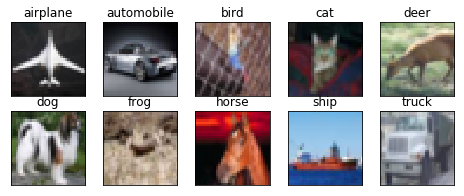

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

###Image Normalization

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# standardizing the image cifar10 dataset

# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()

# report pixel means and standard deviations of train and test datasets
print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainy, batch_size=64)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(64, 32, 32, 3) 0.02664386 1.0631433
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
# Reshape the input to have the dimension for channel
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy

In [0]:
# One - hot encoding
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Rewriting the model again for 50 epochs using the following convolutions:
  
1. Normal Convolution
2. Spatially Separable Convolution  (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))
3. Grouped Convolution (3x3 and 5x5 )
4. Grouped Convolution ( 3x3 , one with dilation = 1, and another with dilation = 2) 
5. Depthwise Separable Convolution

References:

1. https://github.com/toniqapps/EVA-Assignment-6/blob/master/Assignment_6B.ipynb
2. https://github.com/amitdoda1983/EVA-Session-6/blob/master/6B_M6_Amit_Doda.ipynb


In [0]:
# Define the model

from keras.layers import Input
from keras.models import Model

m_input = Input(shape=(32,32,3))

# 1. Normal Convolution
x1 = Conv2D(64, (3, 3), activation='relu',border_mode='same',kernel_regularizer=regularizers.l2(0.0001))(m_input)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.1)(x1)

# 2. Spatially Separable Convolution (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))
'''used immensely in variants of Xception-Incepeption Networks as well as mobile net'''
x1 = Conv2D(128, (3, 1), activation='relu',border_mode='same',kernel_regularizer=regularizers.l2(0.0001))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.1)(x1)

x1 = Conv2D(128, (1, 3), activation='relu',border_mode='same',kernel_regularizer=regularizers.l2(0.0001))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.1)(x1)


x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.1)(x1)

# Bottleneck 1x1 
'''this will reduce parameters
This dimensionality reduction technique prevents 
the number of feature maps to be processed '''
x1 = Conv2D(32, (1, 1), activation='relu')(x1)
x1 = Dropout(0.1)(x1)


# 3. Grouped Convolution (3x3 and 5x5)
''' main motivation of this convolutions is to reduce computational complexity while dividing features into groups
'''
x2 = Conv2D(32, (3, 3), activation='relu',border_mode='same',kernel_regularizer=regularizers.l2(0.0001))(x1)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.1)(x2)


x3 = Conv2D(32, (5, 5), activation='relu',border_mode='same',kernel_regularizer=regularizers.l2(0.0001))(x1)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.1)(x3)

x4 = concatenate([x2,x3])

x4 = MaxPooling2D((2,2))(x4)
x4 = Dropout(0.1)(x4)

# Bottleneck 1x1
'''this will reduce parameters
idea is that after every concatenation; 
a 1 × 1 convolution 
This dimensionality reduction technique prevents 
the number of feature maps to be processed '''
x4 = Conv2D(32, (1, 1), activation='relu')(x4)
x4 = Dropout(0.1)(x4)

# 4. Grouped Conv block Conv2d(3,3) dilation rate (1,1) & Conv2d(3,3) with dilation rate (2,2)
x5 = Conv2D(64, (3, 3), dilation_rate=(1, 1), activation='relu',border_mode='same',kernel_regularizer=regularizers.l2(0.0001))(x4)
x5 = BatchNormalization()(x5)
x5 = Dropout(0.1)(x5)


x6 = Conv2D(64, (3, 3), dilation_rate=(2, 2), activation='relu',border_mode='same',kernel_regularizer=regularizers.l2(0.0001))(x4)
x6 = BatchNormalization()(x6)
x6 = Dropout(0.1)(x6)

x7 = concatenate([x5,x6])

# 5. Depthwise convolution is actually achieved using SeparableConv2D
'''performs a spatial convolution on each channel of its input, 
independently, before mixing output channels 
via a pointwise convolution (a 1 × 1 convolution)

https://eli.thegreenplace.net/2018/depthwise-separable-convolutions-for-machine-learning/

For a depthwise separable convolution on the same example, 
we traverse the 16 channels with 1 3x3 kernel each, 
giving us 16 feature maps. Now, before merging anything, 
we traverse these 16 feature maps with 32 1x1 convolutions each and 
only then start to them add together. 
This results in 656 (16x3x3 + 16x32x1x1) parameters opposed to the 4608 (16x32x3x3) parameters from above.'''

x8 = SeparableConv2D(128,(3, 3), activation='relu',border_mode='same',kernel_regularizer=regularizers.l2(0.0001))(x7)
x8 = BatchNormalization()(x8)

x8 = MaxPooling2D((2,2))(x8)
x8 = Dropout(0.5)(x8)

# Bottleneck 1x1 to reduce params
x8 = Conv2D(10, (1, 1), activation='relu')(x8)
x8 = AveragePooling2D(4,4)(x8)
x8= Flatten()(x8)
x8 = Activation(activation='softmax')(x8)

model = Model(m_input, x8, name='cnn')

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 32, 32, 64)   256         conv2d_11[0][0]                  
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 32, 32, 64)   0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_12 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataG

Epoch 1/50
390/390 [==============================] - 65s 167ms/step - loss: 0.4245 - acc: 0.8877 - val_loss: 0.5651 - val_acc: 0.8519
Epoch 2/50
390/390 [==============================] - 65s 167ms/step - loss: 0.4208 - acc: 0.8894 - val_loss: 0.5048 - val_acc: 0.8710
Epoch 3/50
390/390 [==============================] - 65s 166ms/step - loss: 0.4231 - acc: 0.8900 - val_loss: 0.5182 - val_acc: 0.8643
Epoch 4/50
390/390 [==============================] - 65s 168ms/step - loss: 0.4200 - acc: 0.8881 - val_loss: 0.5403 - val_acc: 0.8583
Epoch 5/50
390/390 [==============================] - 65s 168ms/step - loss: 0.4171 - acc: 0.8909 - val_loss: 0.5302 - val_acc: 0.8656
Epoch 6/50
390/390 [==============================] - 65s 167ms/step - loss: 0.4126 - acc: 0.8914 - val_loss: 0.5223 - val_acc: 0.8642
Epoch 7/50
390/390 [==============================] - 65s 167ms/step - loss: 0.4059 - acc: 0.8954 - val_loss: 0.5035 - val_acc: 0.8712
Epoch 8/50
390/390 [==============================] - 6

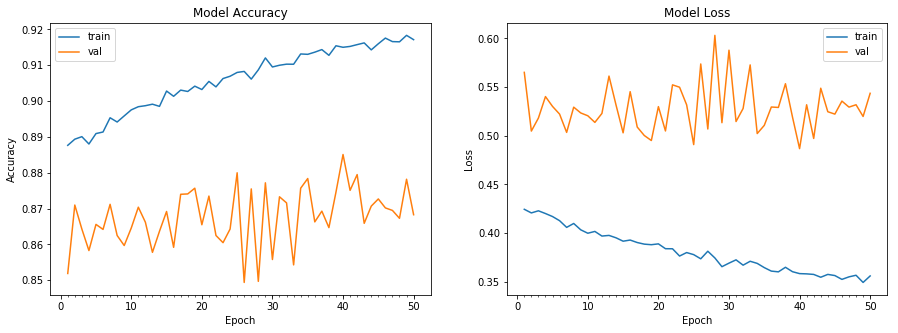

Accuracy on test data is: 86.83


In [0]:
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam

BATCH_SIZE = 64
EPOCHS = 100

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, zoom_range=0.0, horizontal_flip=True)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (X_test, Y_test), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model))

#Observation
Accuracy achieved 88.51% at 40th epoch 